In [1]:
%matplotlib inline
import hashlib
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


D = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '

N = 1024
Z = 8
GAM = 1

M = len(D)

MAX_ITER = 1000

def hamming(x_k, x_l):
    return np.mean(x_k != x_l)

In [2]:
class Encoder(object):
    
    
    def __init__(self, seed, d, n, z, gam):
        self.seed = seed
        self.d = d
        self.m = len(d)
        
        self.n = n
        self.z = z
        self.gam = gam
        
        # sample basis and mask function aux var
        np.random.seed(seed)
        self.x_star = np.random.randint(0, z, n)
        self.xs = [np.random.randint(0, z, n) for i in range (self.m)]
        
        self.seed_offset = np.random.randint(0, 2**32-1)
    
    
    def veil(self, x_k, x_l):
        # get unique RNG seed from x_k and x_l
        str_repr = ''.join(x_k.astype(str)) + ''.join(x_l.astype(str))
        rng_seed = int(hashlib.sha256(str_repr.encode('utf-8')).hexdigest(), 16)  % 10**9
        
        np.random.seed((rng_seed + self.seed_offset)%(2**32))
        
        return np.random.rand(len(x_k))
    
    
    def weave(self, x_k, x_l, t):
        mask = self.veil(x_k, x_l) < 1/(t+1)**self.gam
        u = x_k.copy()
        u[mask] = x_l[mask]
        return u
    
    
    def encode(self, y):
        x_y = self.x_star.copy()
        
        for t, s in enumerate(y, 1):
            idx = self.d.index(s)
            x_y = self.weave(x_y, self.xs[idx], t)
            
        return x_y
    
    
    # functions for exact calculation
    def smty_seq_sbl(self, y, s_i):
        if self.gam != 1:
            raise NotImplementedError
        
        n_i = np.sum(np.array([y_ for y_ in y], dtype='<U1') == s_i)
        l = len(y)
        
        q = n_i/(l+1) + (1/self.z) * (l + 1 - n_i)/(l + 1)

        return q, q*(1-q)/self.n
    
    
    def smty_seq_seq(self, y, y_):
        if self.gam != 1:
            raise NotImplementedError
        
        # get seq lens and shared starting subseq len (t)
        l = len(y)
        l_ = len(y_)
        t = 0
        for s, s_ in zip(y, y_):
            if s == s_:
                t += 1
            else:
                break
        
        assert np.all(y[:t] == y_[:t])
        
        # convert seqs to arrays
        y = np.array([yy for yy in y], dtype='<U1')
        y_ = np.array([yy for yy in y_], dtype='<U1')

        # get symbol count vecs
        n_u = [np.sum(y[:t] == self.d[i]) for i in range(self.m)]
        n_v = [np.sum(y[t:] == self.d[i]) for i in range(self.m)]
        n_v_ = [np.sum(y_[t:] == self.d[i]) for i in range(self.m)]
        
        # calc case probabilites from ms section 4.2
        p_1 = (t+1)**2 / ((l+1)*(l_+1))
        
        p_2 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_v_) + ((l-t)*(l_-t) - np.dot(n_v, n_v_)) * (1/self.z) )
        
        p_3 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_u, n_v_) + ((t+1)*(l_-t) - np.dot(n_u, n_v_)) * (1/self.z) )
        
        p_4 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_u) + ((l-t)*(t+1) - np.dot(n_v, n_u)) * (1/self.z) )
        
        # sum case probabilities
        q = p_1 + p_2 + p_3 + p_4
        
        return q, q*(1-q)/self.n
    
    
class Decoder(object):
    
    def __init__(self, encoder):
        self.e = encoder
        
    
    def decode(self, x_y, l=None, return_dst=False, force=None, max_iter=MAX_ITER):
        
        # get set of elements in sequence
        min_idxs = np.argsort([hamming(x, x_y) for x in self.e.xs])
        vs = [self.e.xs[idx] for idx in min_idxs]
        
        # reconstruct sequence
        x_y_star = self.e.x_star.copy()
        y_hat = ''
        dst = [hamming(x_y_star, x_y)]
        
        for t in range(1, max_iter):
            
            us = [self.e.weave(x_y_star, v, t) for v in vs]
            dst_ = [hamming(u, x_y) for u in us]
            j = np.argmin(dst_)
            
            if l is None and dst_[j] >= dst[-1]:
                break

            if force is not None and len(force) >= t:
                next_sym = force[t-1]
                next_x = self.e.xs[self.d.index(next_sym)]
            else:
                next_sym = self.e.d[min_idxs[j]]
                next_x = vs[j]

            y_hat += next_sym
            x_y_star = self.e.weave(x_y_star, next_x, t)
            dst.append(hamming(x_y_star, x_y))
            
            if t == l:
                break

        if not return_dst:
            return y_hat
        else:
            return y_hat, np.array(dst)

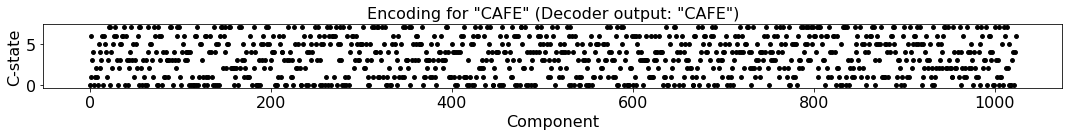

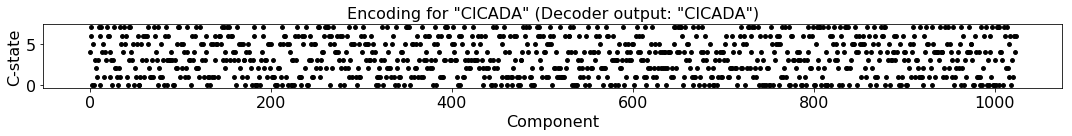

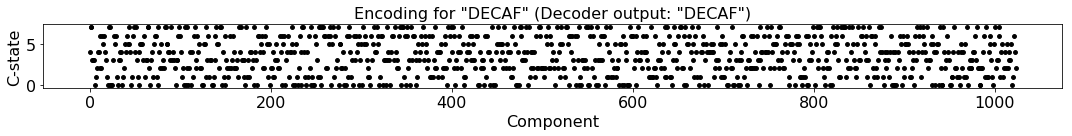

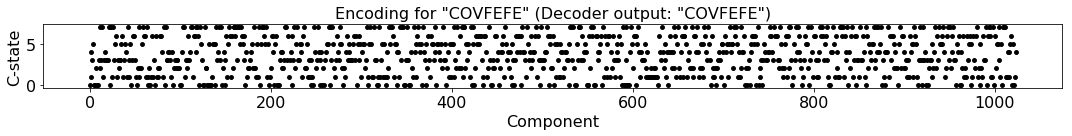

In [3]:
encoder = Encoder(0, D, N, 8, GAM)
decoder = Decoder(encoder)

for y in ['CAFE', 'CICADA', 'DECAF', 'COVFEFE']:

    x = encoder.encode(y)
    fig, ax = plt.subplots(1, 1, figsize=(15, 2), tight_layout=True)
    ax.scatter(range(len(x)), x, s=15, c='k')
    ax.set_xlabel('Component')
    ax.set_ylabel('C-state')
    ax.set_title('Encoding for "{}" (Decoder output: "{}")'.format(y, decoder.decode(x)))
    set_font_size(ax, 16)

(Y, Y_HAT, Y_HAT_NOISY) = (CAFE, CAFE, CAFE)
(Y, Y_HAT, Y_HAT_NOISY) = (CICADA, CICADA, CICADA)


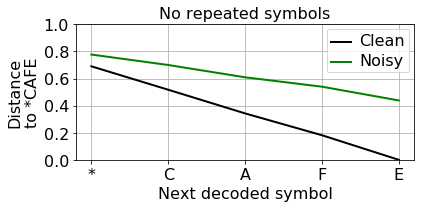

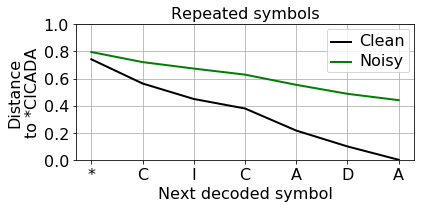

In [4]:
encoder = Encoder(0, D, N, Z, GAM)
decoder = Decoder(encoder)
noise = N // 2

for y in ['CAFE', 'CICADA']:
    x = encoder.encode(y)
    x_noisy = x.copy()
    x_noisy[np.random.permutation(N)[:noise]] = np.random.randint(0, Z, noise)
    
    y_hat, dst = decoder.decode(x, return_dst=True)
    y_hat_noisy, dst_noisy = decoder.decode(x_noisy, return_dst=True)
    
    print('(Y, Y_HAT, Y_HAT_NOISY) = ({}, {}, {})'.format(y, y_hat, y_hat_noisy))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
    
    ax.plot(range(len(y) + 1), dst, c='k', lw=2)
    ax.plot(range(len(y) + 1), dst_noisy, c='g', lw=2)

    ax.set_xticks(range(len(y) + 1))
    ax.set_ylim(0, 1)
    
    ax.set_xticklabels('*' + y)
    ax.set_xlabel('Next decoded symbol')
    ax.set_ylabel('Distance\nto *' + y)
    
    if y == 'CAFE':
        ax.set_title('No repeated symbols')
    elif y == 'CICADA':
        ax.set_title('Repeated symbols')
        
    ax.legend(['Clean', 'Noisy'])
    ax.grid()
    
    set_font_size(ax, 16)

In [5]:
noise = np.round(N*np.linspace(.75, 1., 11)).astype(int)
n_trials = 100
ys = ['CAFE', 'CICADA']

p_correct = np.nan * np.zeros((len(ys), len(noise)))

for n_ctr, noise_ in enumerate(noise):
    print('noise_ = {}'.format(noise_))
    
    ct_correct = np.zeros(len(ys))
    
    for seed in range(n_trials):
        encoder = Encoder(seed, D, N, Z, GAM)
        decoder = Decoder(encoder)
        
        for y_ctr, y in enumerate(ys):
            x = encoder.encode(y)
            x_noisy = x.copy()
            x_noisy[np.random.permutation(N)[:noise_]] = np.random.randint(0, Z, noise_)
            
            y_hat = decoder.decode(x_noisy)
            if y_hat == y:
                ct_correct[y_ctr] += 1
                
    p_correct[:, n_ctr] = ct_correct / n_trials

noise_ = 768
noise_ = 794
noise_ = 819
noise_ = 845
noise_ = 870
noise_ = 896
noise_ = 922
noise_ = 947
noise_ = 973
noise_ = 998
noise_ = 1024


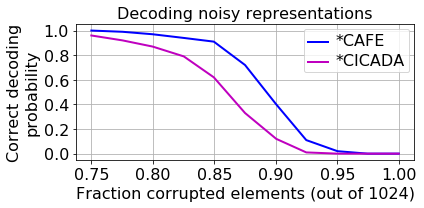

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
cs = ['b', 'm']
for ctr in range(len(ys)):
    ax.plot(noise/N, p_correct[ctr], c=cs[ctr], lw=2)

ax.set_xlabel('Fraction corrupted elements (out of {})'.format(N))
ax.set_ylabel('Correct decoding\nprobability')
ax.set_title('Decoding noisy representations')
ax.legend(['*' + y for y in ys])

ax.grid()

set_font_size(ax, 16)